# Data Visualsation

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from optum_challenge.visualisation import plot_bar_chart, plot_normalised_bar_chart_hue, keep_levels_greater_than_pct

In [2]:
df = pd.read_parquet('data_combined_for_eda')

In [3]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,region,district_code,lga,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group
0,69572,6000,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,0,Lake Nyasa,Iringa,5,Ludewa,109,TRUE,VWC,Roman,FALSE,1999,gravity,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional
1,8776,0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,0,Lake Victoria,Mara,2,Serengeti,280,None,Other,None,TRUE,2010,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,0,Pangani,Manyara,4,Simanjiro,250,TRUE,VWC,Nyumba ya mungu pipe scheme,TRUE,2009,gravity,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,67743,0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,58,TRUE,VWC,None,TRUE,1986,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,0,2011-07-13,Action In A,0.0,Artisan,31.130847,-1.825359,0,Lake Victoria,Kagera,1,Karagwe,0,TRUE,None,None,TRUE,0,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


## Target

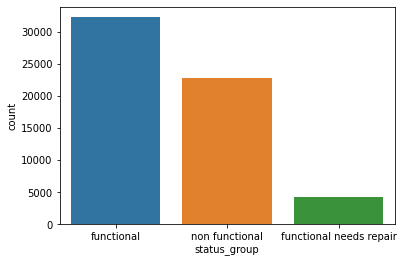

In [4]:
sns.countplot(df.status_group)

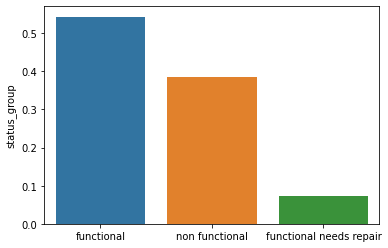

In [5]:
sns.barplot(x=df.status_group.value_counts().index, y = df.status_group.value_counts(normalize=True))

This is a multi-class problem with 3 levels, with functional needs repair being in a strong minority

In [6]:
# trying to keep colours consistent
colours = {'functional': 'blue',
           'non functional': 'orange',
           'functional needs repair': 'green'}

# looking at continous variables first

In [7]:
cat_cols = df.select_dtypes('object').columns

In [8]:
contin_cols = [col for col in df.columns if col == 'status_group' or col not in cat_cols]

In [9]:
df_contin = df[contin_cols]

## amount_tsh

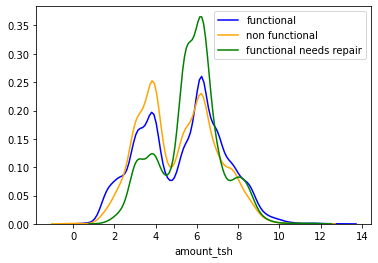

In [10]:
sns.distplot(np.log(df_contin[(df_contin.amount_tsh > 0) & (df_contin.status_group == 'functional')].amount_tsh), hist=False, color=colours['functional'], label='functional')
sns.distplot(np.log(df_contin[(df_contin.amount_tsh > 0) & (df_contin.status_group == 'non functional')].amount_tsh), hist=False, color=colours['non functional'], label='non functional')
sns.distplot(np.log(df_contin[(df_contin.amount_tsh > 0) & (df_contin.status_group == 'functional needs repair')].amount_tsh), hist=False, color=colours['functional needs repair'], label='functional needs repair')
plt.legend()

There appears to be alot of zeros in this field and goes over several orders of magnitude. I suspect that the zero values are bad data as seems unlikely so many are empty. Each label seems to have different distrubtions of amount_tsh

# date_recorded

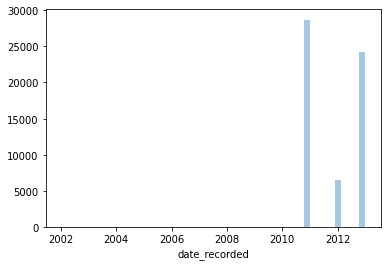

In [11]:
sns.distplot(df_contin.date_recorded.dt.year, kde=False)

In [12]:
df.date_recorded.dt.year.value_counts()

2011    28672
2013    24270
2012     6424
2004       30
2002        1
Name: date_recorded, dtype: int64

Vast majority of the data is from 2011 or later with very few records from before. For training, I may drop records before then

## gps_height

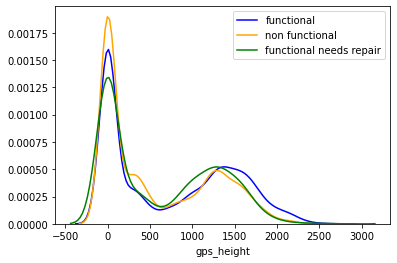

In [14]:
sns.distplot(df_contin[df_contin.status_group == 'functional'].gps_height, hist=False, color=colours['functional'], label='functional')
sns.distplot(df_contin[df_contin.status_group == 'non functional'].gps_height, hist=False, color=colours['non functional'], label='non functional')
sns.distplot(df_contin[df_contin.status_group == 'functional needs repair'].gps_height, hist=False, color=colours['functional needs repair'], label='functional needs repair')

plt.legend()

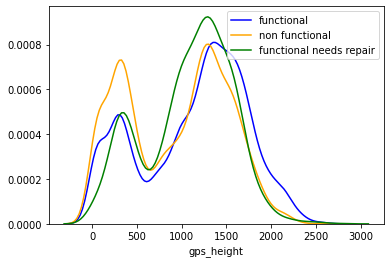

In [16]:
sns.distplot(df_contin[(df_contin.gps_height > 0) & (df_contin.status_group == 'functional')].gps_height, hist=False, color=colours['functional'], label='functional')
sns.distplot(df_contin[(df_contin.gps_height > 0) & (df_contin.status_group == 'non functional')].gps_height, hist=False, color=colours['non functional'], label='non functional')
sns.distplot(df_contin[(df_contin.gps_height > 0) & (df_contin.status_group == 'functional needs repair')].gps_height, hist=False, color=colours['functional needs repair'], label='functional needs repair')
plt.legend()

There are some differences with gps height, however its hard to tell by itself, towns could be just clustered at about 400 and 1500.

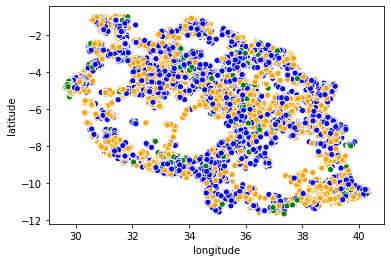

In [17]:
sns.scatterplot(x = df_contin[df_contin.longitude > 0].longitude, y = df_contin[df_contin.latitude < 0].latitude, hue=df_contin.status_group, palette=colours,legend=False)

In [18]:
df.latitude.max()

-2e-08

In [19]:
df.longitude.min()

0.0

There is a bad datapoint at longtitud 0 and latitude 0. Other than that, I dont see any obvious area where there are clusters of functional. There might be areas higher numbers of needs repair but hard to say. In a model such as logistic, each feature is meant to be independent of each other meaning, strictly, co-ordinates shouldn't be used without some kind of extra work. In something like tree based methods, this is less of a problem and may be able to model the outcome for these featuers better. If I had more time I would look into some GIS techniques for extracting more features from these.

## num_private

Not much information is given about this, it's mainly zero values. I may make this a binary column when modelling

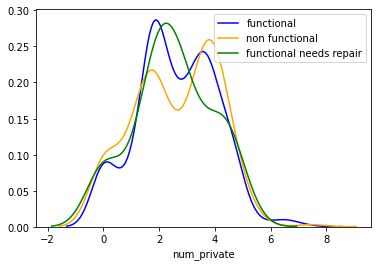

In [20]:
sns.distplot(np.log(df_contin[((df_contin.num_private > 0)) & (df_contin.status_group == 'functional')].num_private), hist=False, color=colours['functional'], label='functional')
sns.distplot(np.log(df_contin[(df_contin.num_private > 0) & (df_contin.status_group == 'non functional')].num_private), hist=False, color=colours['non functional'], label='non functional')
sns.distplot(np.log(df_contin[(df_contin.num_private > 0) & (df_contin.status_group == 'functional needs repair')].num_private), hist=False, color=colours['functional needs repair'], label='functional needs repair')
plt.legend()

In [21]:
df_contin.num_private.quantile(np.linspace(0.988,1,11))

0.9880       1.0000
0.9892       3.0000
0.9904       5.0000
0.9916       6.0000
0.9928       8.0000
0.9940      15.0000
0.9952      29.6976
0.9964      39.0000
0.9976      47.0000
0.9988      93.0000
1.0000    1776.0000
Name: num_private, dtype: float64

## population

* clear and obvious outliers that can be removed/capped during modelling
* zero is probably missing data

In [22]:
df_contin.population.quantile(np.linspace(0,1,11))

0.0     -200.0
0.1        0.0
0.2        0.0
0.3        0.0
0.4        1.0
0.5       25.0
0.6       90.0
0.7      160.0
0.8      260.0
0.9      453.0
1.0    30500.0
Name: population, dtype: float64

(0.0, 1000.0)

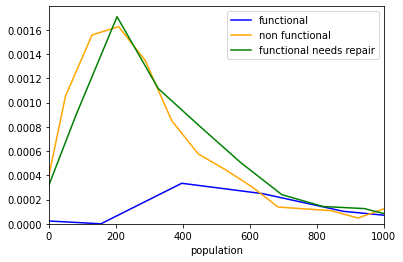

In [23]:
sns.distplot(df_contin[(df_contin.population > 0) & (df_contin.status_group == 'functional')].population, hist=False, color=colours['functional'], label='functional')
sns.distplot(df_contin[(df_contin.population > 0) & (df_contin.status_group == 'non functional')].population, hist=False, color=colours['non functional'], label='non functional')
sns.distplot(df_contin[(df_contin.population > 0) & (df_contin.status_group == 'functional needs repair')].population, hist=False, color=colours['functional needs repair'], label='functional needs repair')
plt.legend()
plt.xlim([0,1000])

In [24]:
df_contin.head()

,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,population,construction_year,status_group
0,6000,2011-03-14,1390.0,34.938093,-9.856322,0,109,1999,functional
1,0,2013-03-06,1399.0,34.698766,-2.147466,0,280,2010,functional
2,25,2013-02-25,686.0,37.460664,-3.821329,0,250,2009,functional
3,0,2013-01-28,263.0,38.486161,-11.155298,0,58,1986,non functional
4,0,2011-07-13,0.0,31.130847,-1.825359,0,0,0,functional


## year constructed

* could make feature when modelling using this and date recorded to find age at recording
* zero looks like missing data
* clear and intuative relationship with when it was built and status. Older ones have a higher proportion of non functioning or needs repaiting, then this swaps for modern ones.

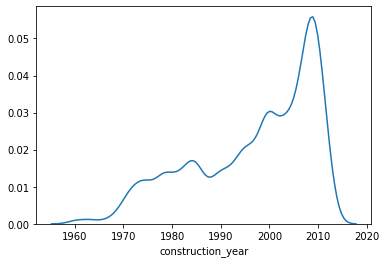

In [25]:
sns.distplot(df_contin[df_contin.construction_year > 0].construction_year, hist=False)

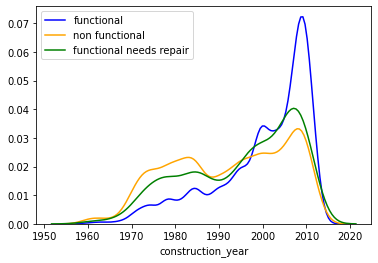

In [26]:
sns.distplot(df_contin[(df_contin.construction_year > 0) & (df_contin.status_group == 'functional')].construction_year, hist=False, color=colours['functional'], label='functional')
sns.distplot(df_contin[(df_contin.construction_year > 0) & (df_contin.status_group == 'non functional')].construction_year, hist=False, color=colours['non functional'], label='non functional')
sns.distplot(df_contin[(df_contin.construction_year > 0) & (df_contin.status_group == 'functional needs repair')].construction_year, hist=False, color=colours['functional needs repair'], label='functional needs repair')
plt.legend()

# Categorical features

In [27]:
df_cat = df[cat_cols]

In [28]:
df_cat.head()

,id,funder,installer,basin,region,district_code,lga,public_meeting,scheme_management,scheme_name,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group
0,69572,Roman,Roman,Lake Nyasa,Iringa,5,Ludewa,TRUE,VWC,Roman,FALSE,gravity,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional
1,8776,Grumeti,GRUMETI,Lake Victoria,Mara,2,Serengeti,None,Other,None,TRUE,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,Lottery Club,World vision,Pangani,Manyara,4,Simanjiro,TRUE,VWC,Nyumba ya mungu pipe scheme,TRUE,gravity,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,67743,Unicef,UNICEF,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,TRUE,VWC,None,TRUE,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,Action In A,Artisan,Lake Victoria,Kagera,1,Karagwe,TRUE,None,None,TRUE,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


## Funder

In [29]:
funder_keep = keep_levels_greater_than_pct(df=df_cat, column='funder')

AxesSubplot(0.125,0.125;0.775x0.755)


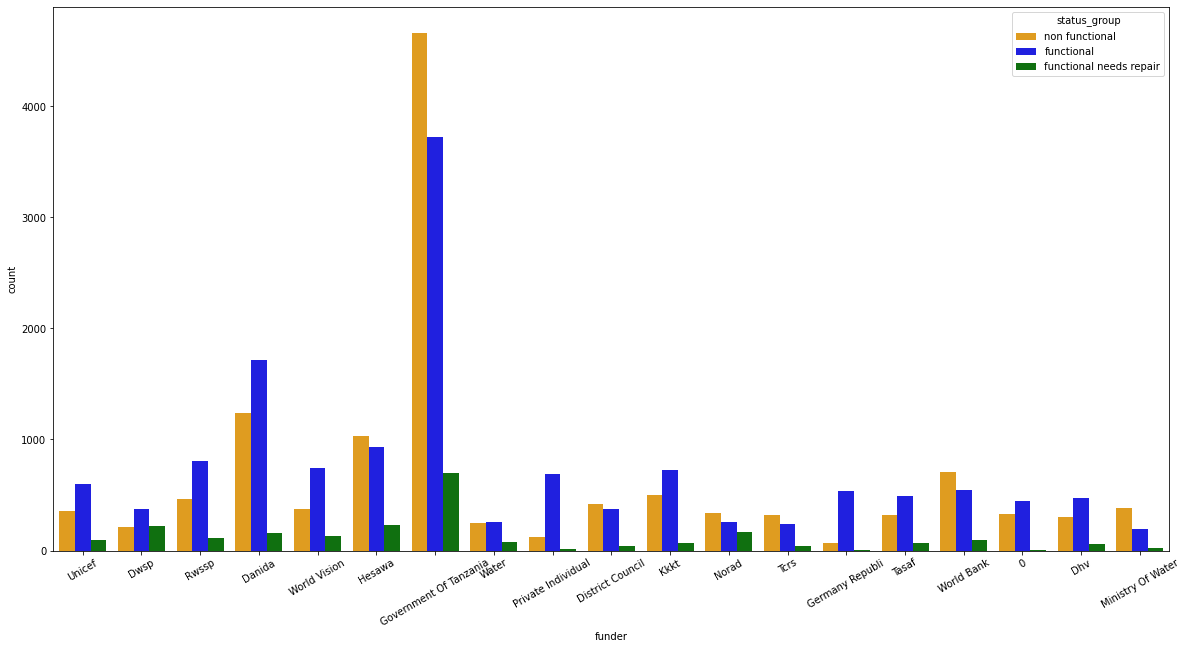

In [30]:
plot_bar_chart(df_cat[df_cat.funder.isin(funder_keep)], column='funder')

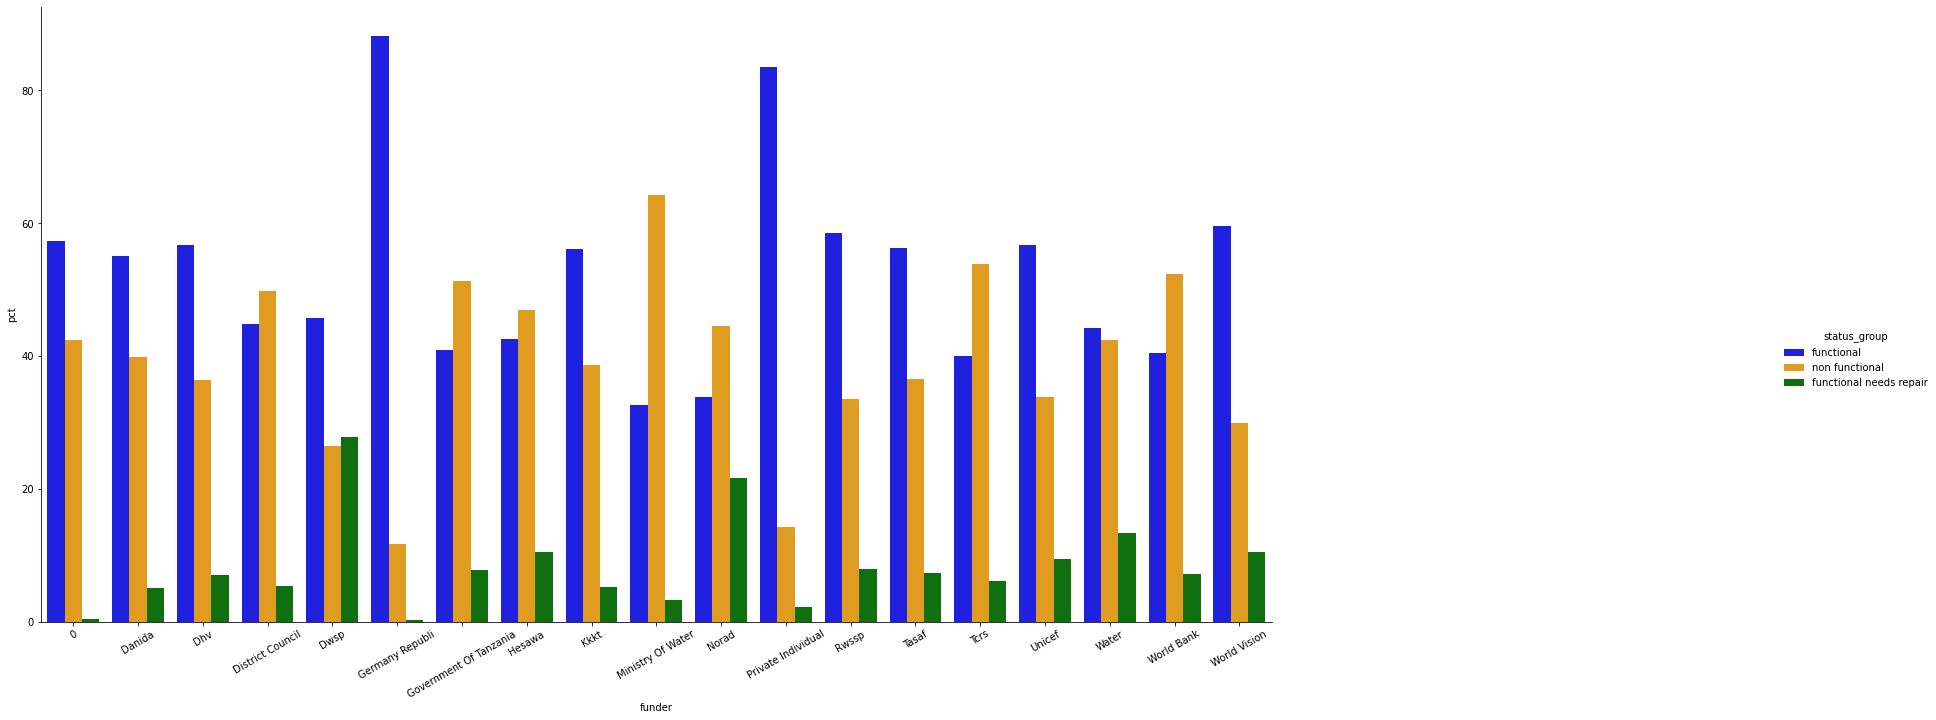

In [31]:
plot_normalised_bar_chart_hue(df[df.funder.isin(funder_keep)], column='funder')

In [32]:
df_cat.head()

,id,funder,installer,basin,region,district_code,lga,public_meeting,scheme_management,scheme_name,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group
0,69572,Roman,Roman,Lake Nyasa,Iringa,5,Ludewa,TRUE,VWC,Roman,FALSE,gravity,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional
1,8776,Grumeti,GRUMETI,Lake Victoria,Mara,2,Serengeti,None,Other,None,TRUE,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,Lottery Club,World vision,Pangani,Manyara,4,Simanjiro,TRUE,VWC,Nyumba ya mungu pipe scheme,TRUE,gravity,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,67743,Unicef,UNICEF,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,TRUE,VWC,None,TRUE,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,Action In A,Artisan,Lake Victoria,Kagera,1,Karagwe,TRUE,None,None,TRUE,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


# Installer

In [33]:
installer_keep = keep_levels_greater_than_pct(df=df_cat, column='installer')

AxesSubplot(0.125,0.125;0.775x0.755)


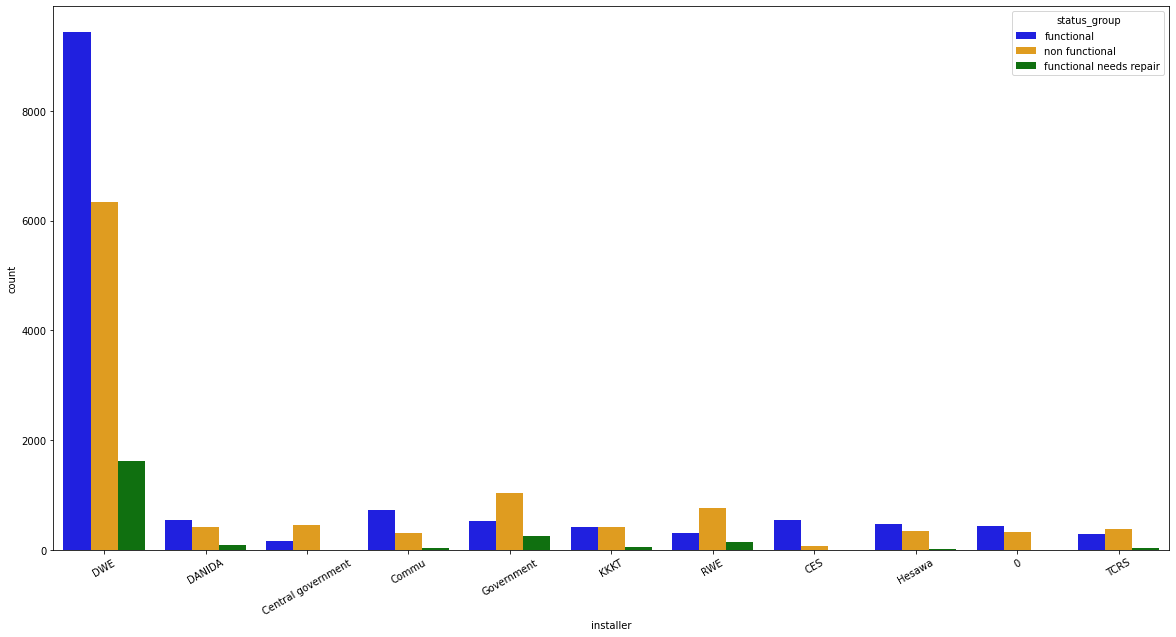

In [34]:
plot_bar_chart(df_cat[df_cat.installer.isin(installer_keep)], column='installer')

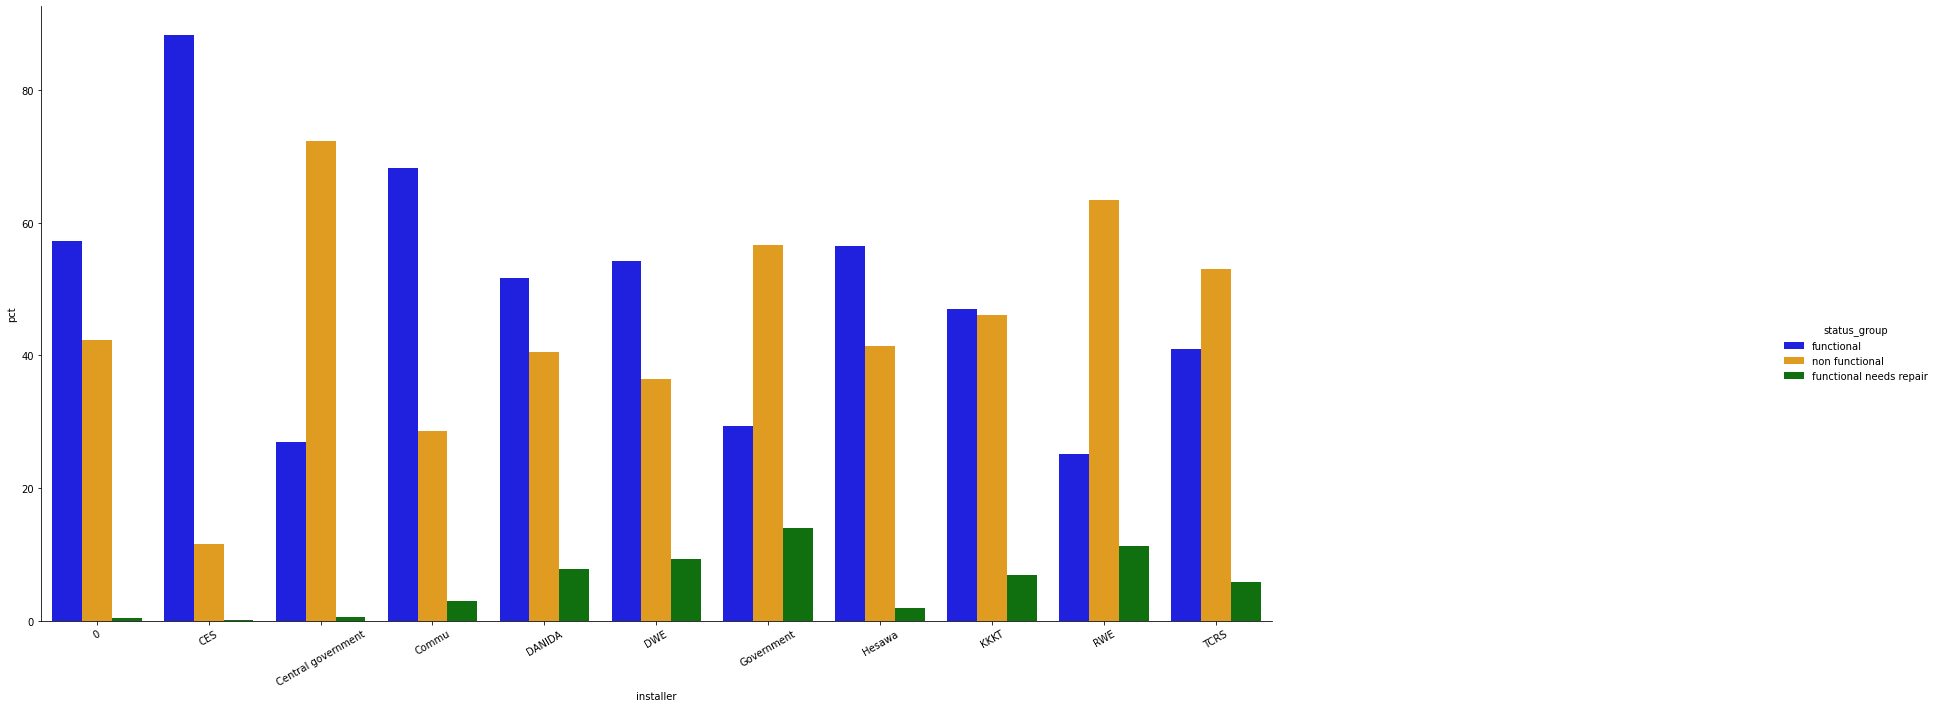

In [35]:
plot_normalised_bar_chart_hue(df[df.installer.isin(installer_keep)], column='installer')

In [36]:
df_cat.head()

,id,funder,installer,basin,region,district_code,lga,public_meeting,scheme_management,scheme_name,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group
0,69572,Roman,Roman,Lake Nyasa,Iringa,5,Ludewa,TRUE,VWC,Roman,FALSE,gravity,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional
1,8776,Grumeti,GRUMETI,Lake Victoria,Mara,2,Serengeti,None,Other,None,TRUE,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,Lottery Club,World vision,Pangani,Manyara,4,Simanjiro,TRUE,VWC,Nyumba ya mungu pipe scheme,TRUE,gravity,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,67743,Unicef,UNICEF,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,TRUE,VWC,None,TRUE,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,Action In A,Artisan,Lake Victoria,Kagera,1,Karagwe,TRUE,None,None,TRUE,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


AxesSubplot(0.125,0.125;0.775x0.755)


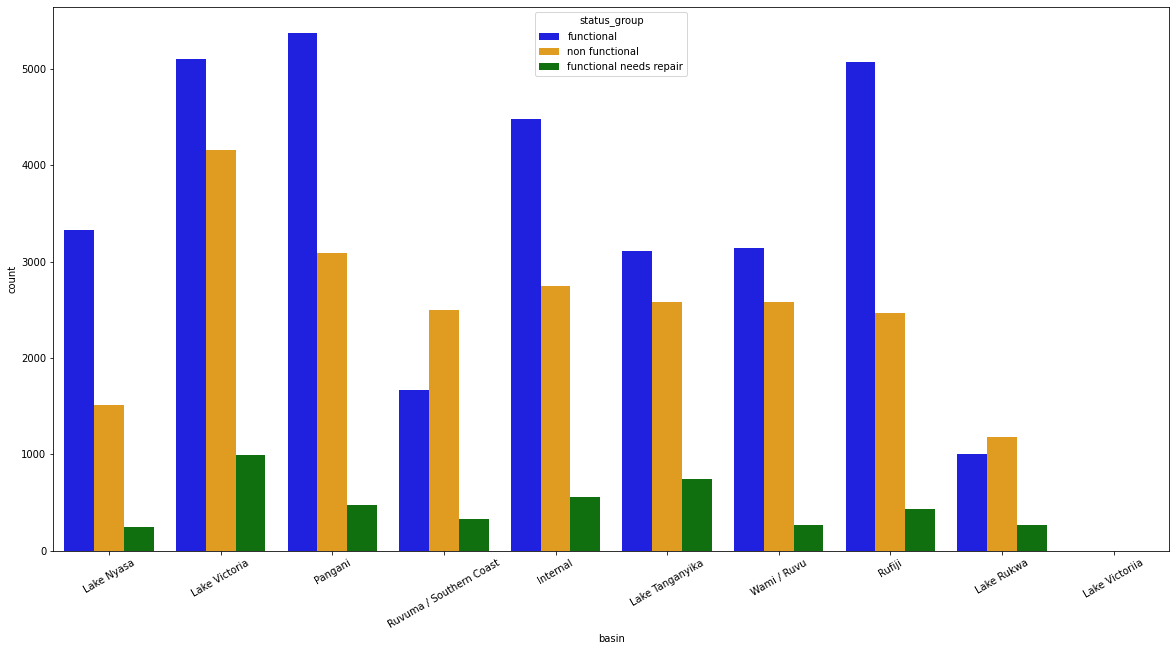

In [37]:
plot_bar_chart(df_cat, column='basin')

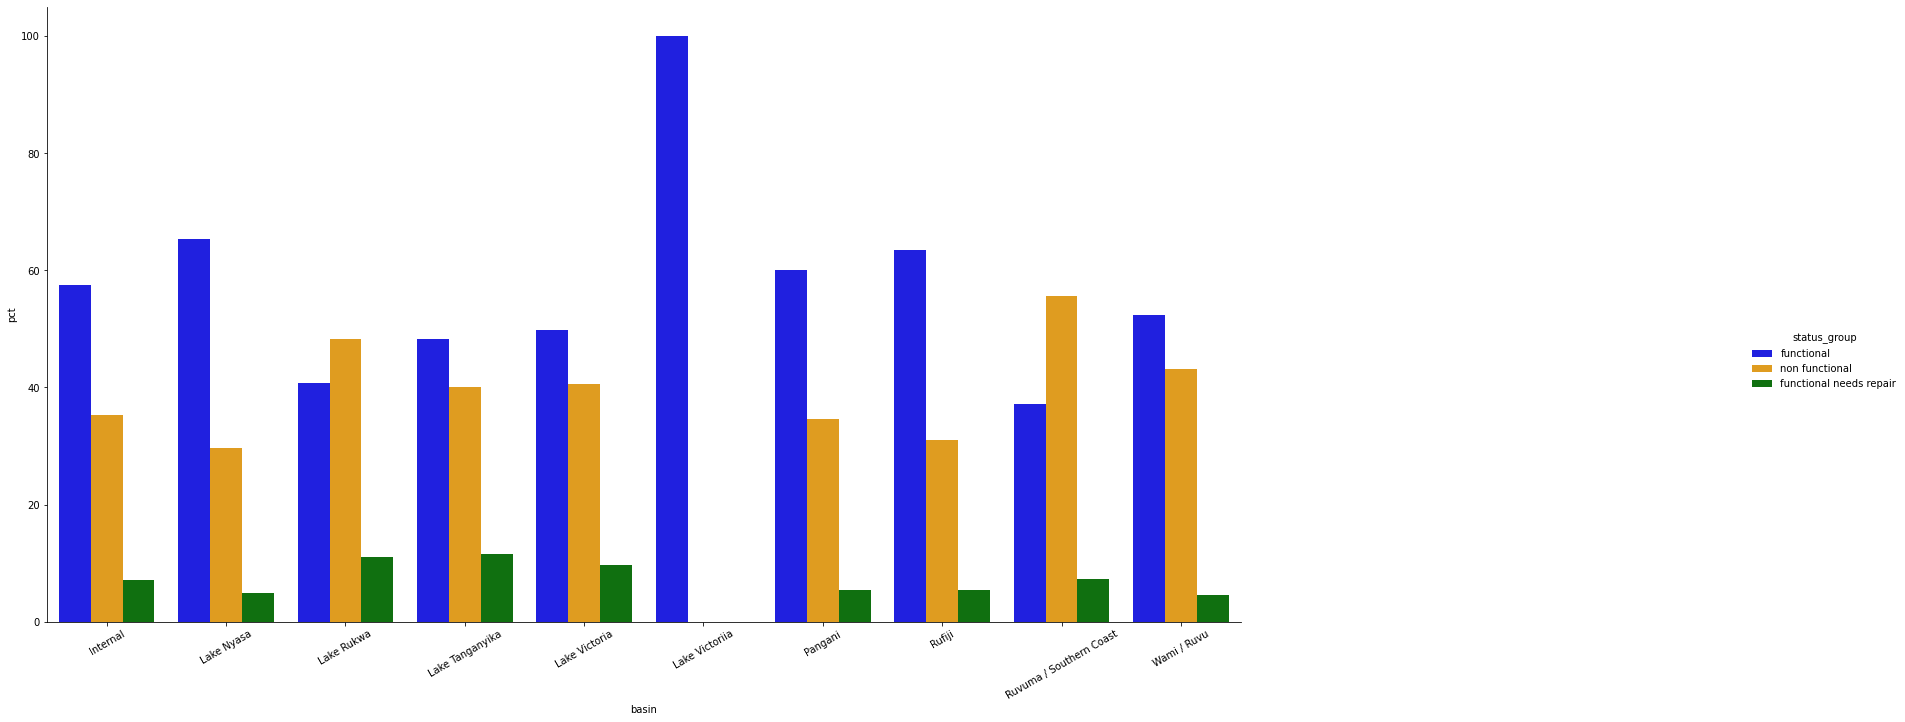

In [38]:
plot_normalised_bar_chart_hue(df_cat, column='basin')

In [39]:
df_cat.head()

,id,funder,installer,basin,region,district_code,lga,public_meeting,scheme_management,scheme_name,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group
0,69572,Roman,Roman,Lake Nyasa,Iringa,5,Ludewa,TRUE,VWC,Roman,FALSE,gravity,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional
1,8776,Grumeti,GRUMETI,Lake Victoria,Mara,2,Serengeti,None,Other,None,TRUE,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,Lottery Club,World vision,Pangani,Manyara,4,Simanjiro,TRUE,VWC,Nyumba ya mungu pipe scheme,TRUE,gravity,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,67743,Unicef,UNICEF,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,TRUE,VWC,None,TRUE,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,Action In A,Artisan,Lake Victoria,Kagera,1,Karagwe,TRUE,None,None,TRUE,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [40]:
region_keep = keep_levels_greater_than_pct(df=df_cat, column='region')

AxesSubplot(0.125,0.125;0.775x0.755)


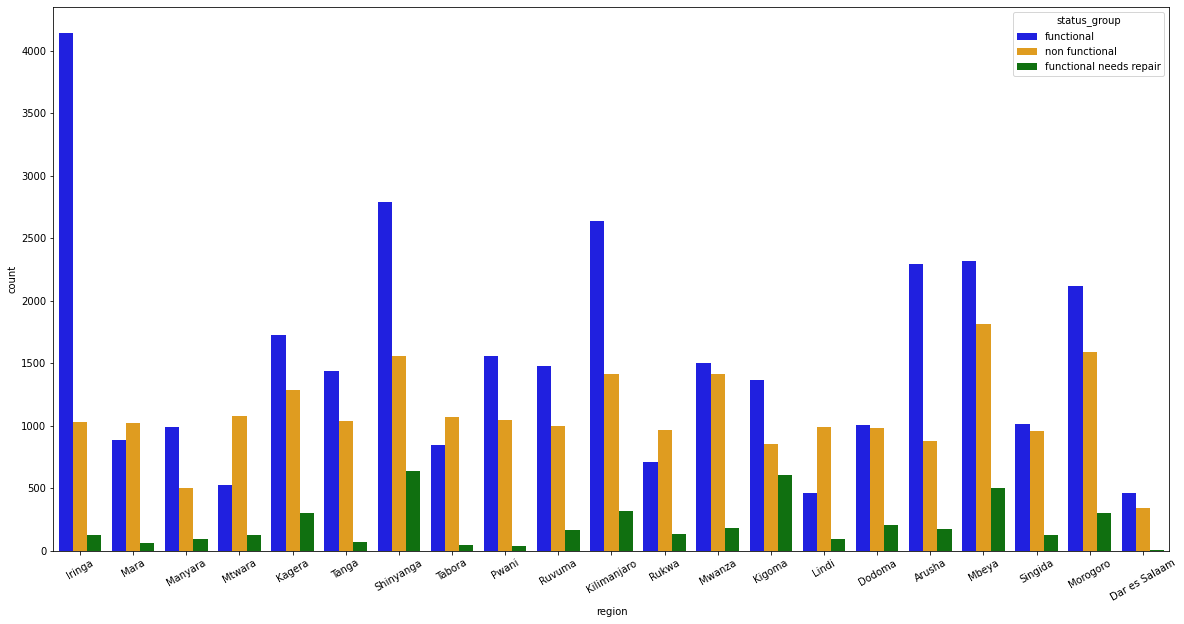

In [41]:
plot_bar_chart(df_cat[df_cat.region.isin(region_keep)], column='region')

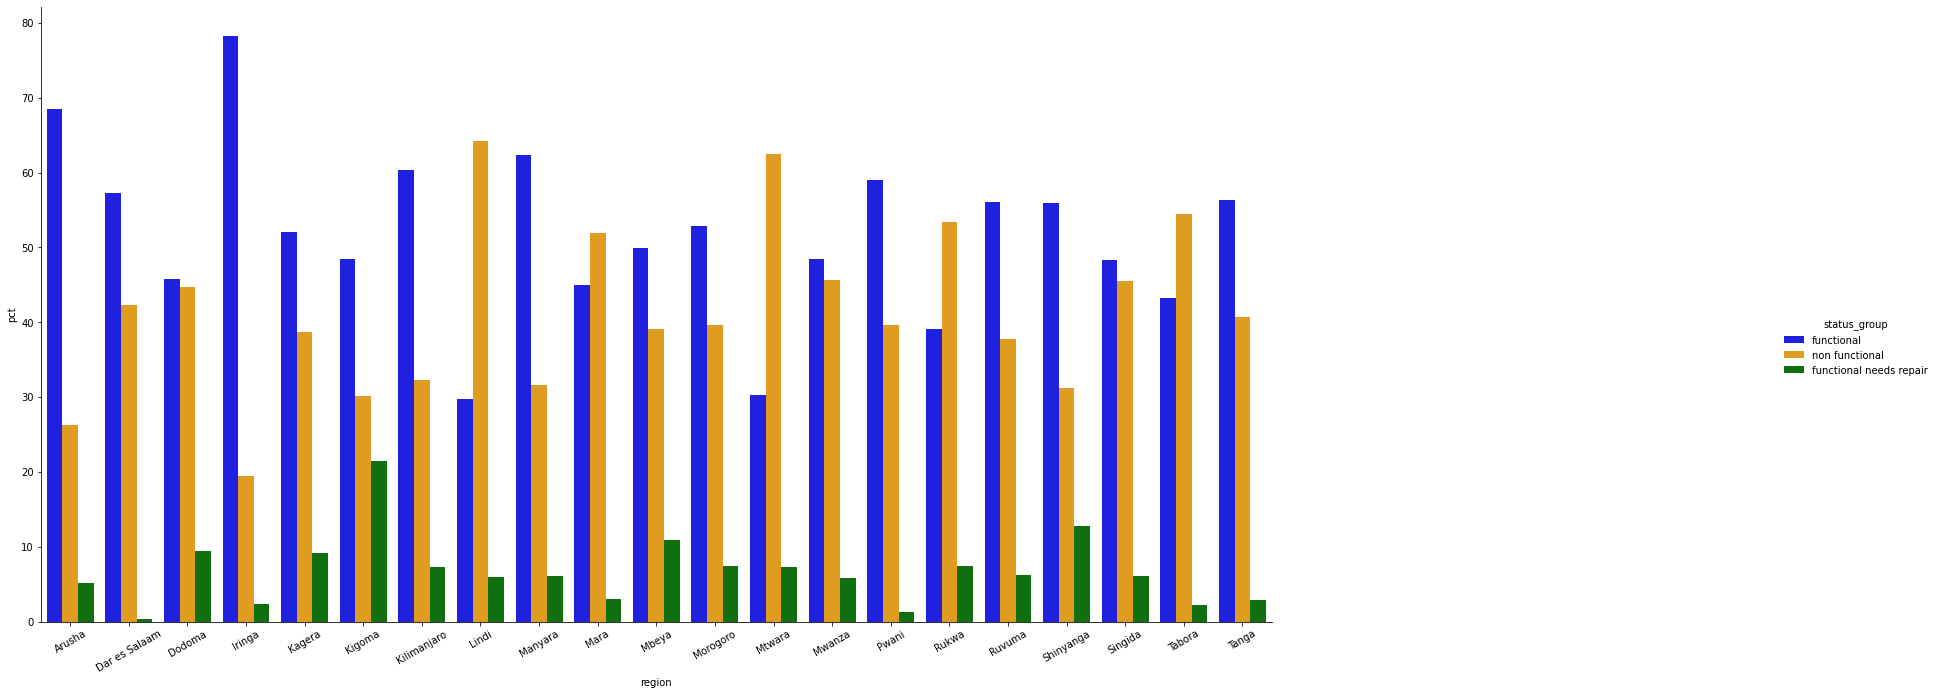

In [42]:
plot_normalised_bar_chart_hue(df_cat[df_cat.region.isin(region_keep)], column='region')

In [43]:
df_cat.head()

,id,funder,installer,basin,region,district_code,lga,public_meeting,scheme_management,scheme_name,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group
0,69572,Roman,Roman,Lake Nyasa,Iringa,5,Ludewa,TRUE,VWC,Roman,FALSE,gravity,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional
1,8776,Grumeti,GRUMETI,Lake Victoria,Mara,2,Serengeti,None,Other,None,TRUE,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,Lottery Club,World vision,Pangani,Manyara,4,Simanjiro,TRUE,VWC,Nyumba ya mungu pipe scheme,TRUE,gravity,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,67743,Unicef,UNICEF,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,TRUE,VWC,None,TRUE,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,Action In A,Artisan,Lake Victoria,Kagera,1,Karagwe,TRUE,None,None,TRUE,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [44]:
district_code_keep = keep_levels_greater_than_pct(df=df_cat, column='district_code')

AxesSubplot(0.125,0.125;0.775x0.755)


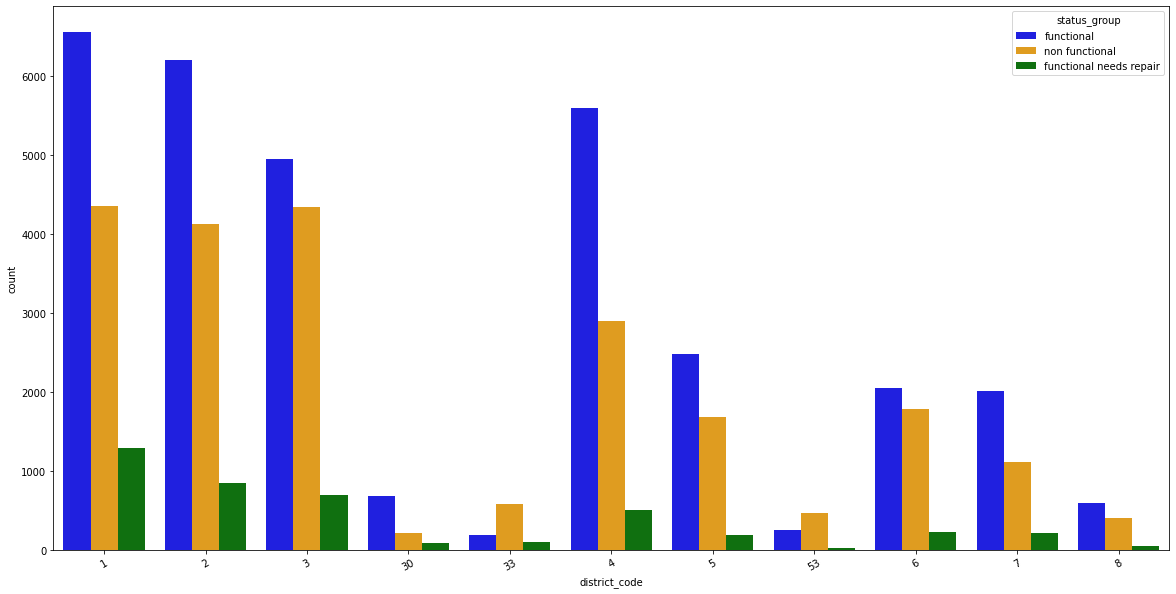

In [45]:
plot_bar_chart(df_cat[df_cat.district_code.isin(district_code_keep)], column='district_code')

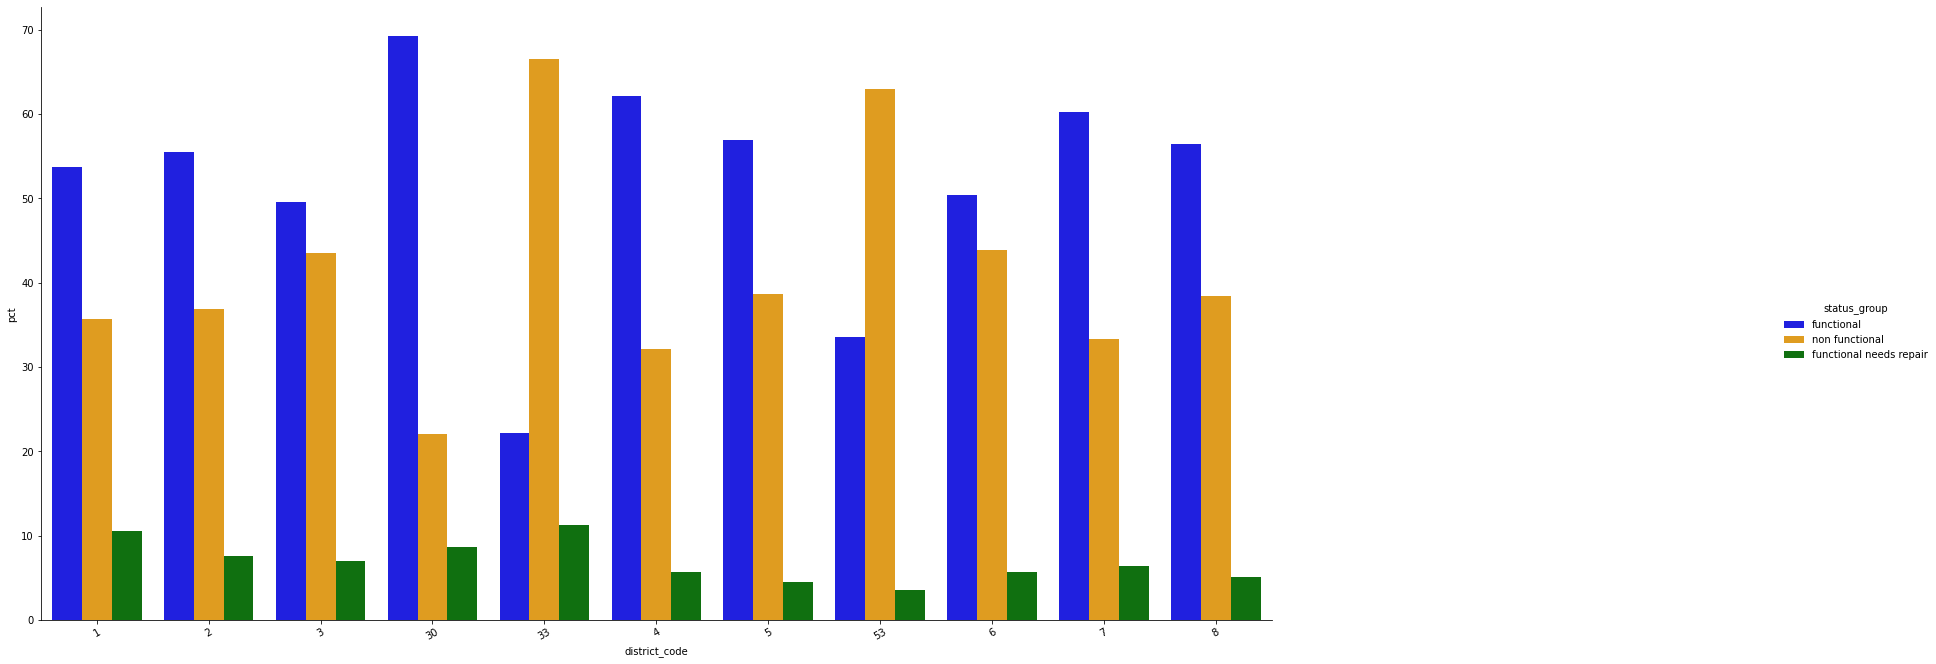

In [46]:
plot_normalised_bar_chart_hue(df_cat[df_cat.district_code.isin(district_code_keep)], column='district_code')

In [47]:
lga_keep = keep_levels_greater_than_pct(df=df_cat, column='lga')

AxesSubplot(0.125,0.125;0.775x0.755)


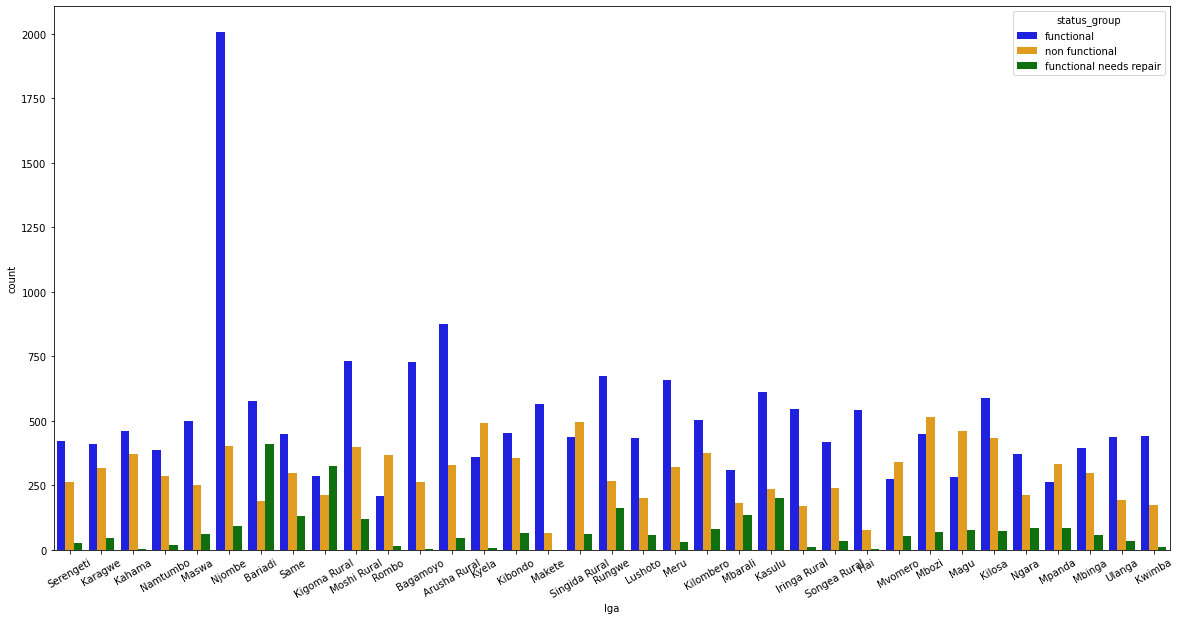

In [48]:
plot_bar_chart(df_cat[df_cat.lga.isin(lga_keep)], column='lga')

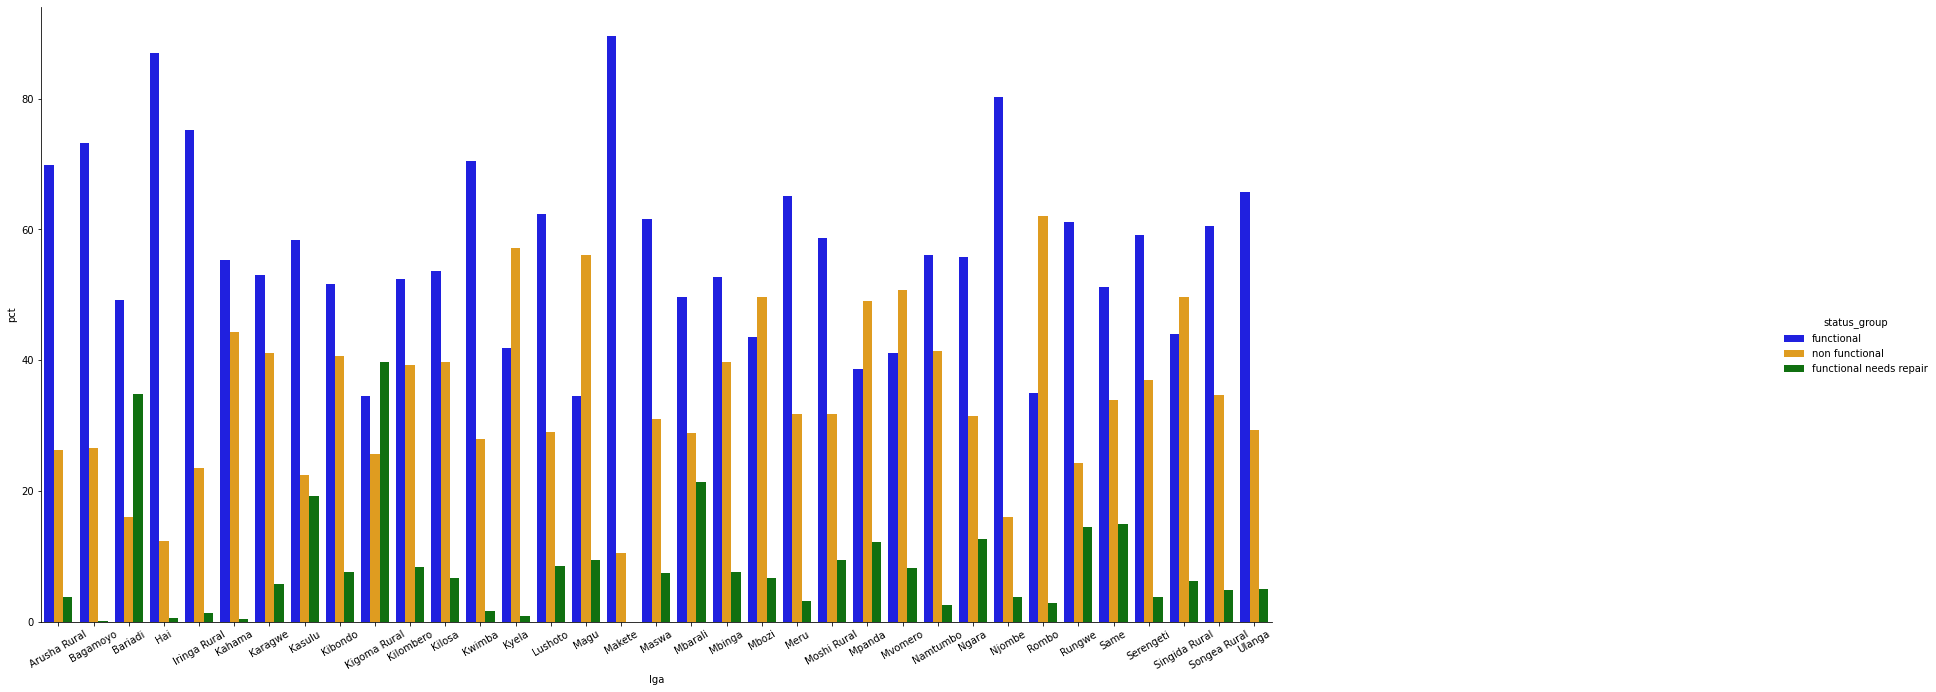

In [49]:
plot_normalised_bar_chart_hue(df_cat[df_cat.lga.isin(lga_keep)], column='lga')

In [50]:
df_cat.head()

,id,funder,installer,basin,region,district_code,lga,public_meeting,scheme_management,scheme_name,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group
0,69572,Roman,Roman,Lake Nyasa,Iringa,5,Ludewa,TRUE,VWC,Roman,FALSE,gravity,vwc,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional
1,8776,Grumeti,GRUMETI,Lake Victoria,Mara,2,Serengeti,None,Other,None,TRUE,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,Lottery Club,World vision,Pangani,Manyara,4,Simanjiro,TRUE,VWC,Nyumba ya mungu pipe scheme,TRUE,gravity,vwc,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,67743,Unicef,UNICEF,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,TRUE,VWC,None,TRUE,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,Action In A,Artisan,Lake Victoria,Kagera,1,Karagwe,TRUE,None,None,TRUE,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [51]:
df_cat.public_meeting.value_counts(dropna=False)

TRUE     51009
FALSE     5054
NaN       3334
Name: public_meeting, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


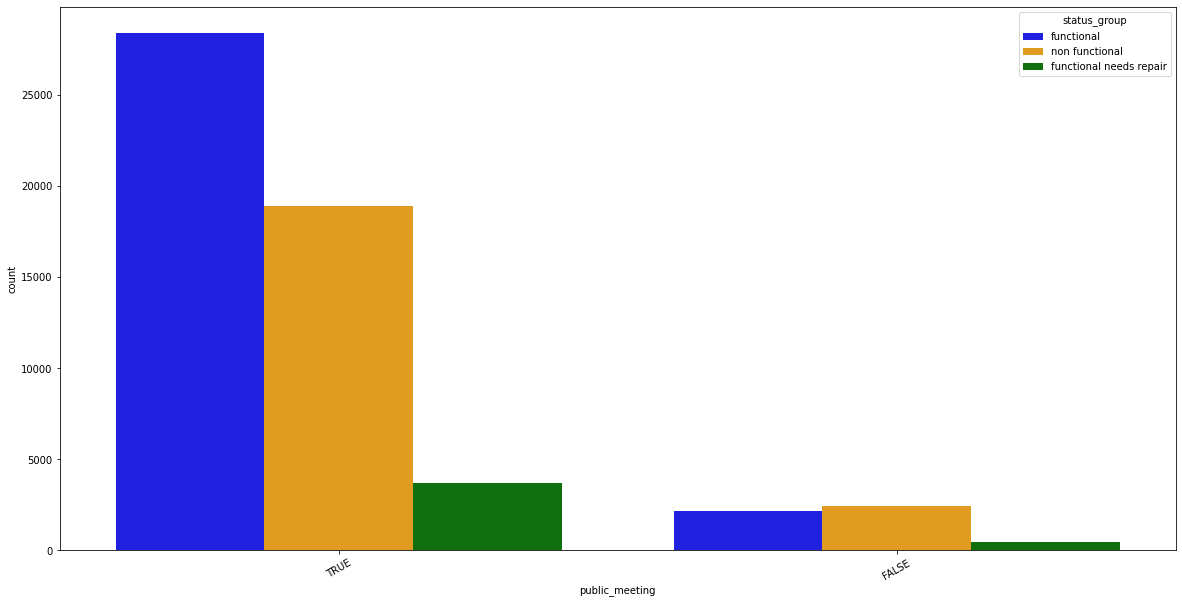

In [52]:
plot_bar_chart(df_cat, column='public_meeting')

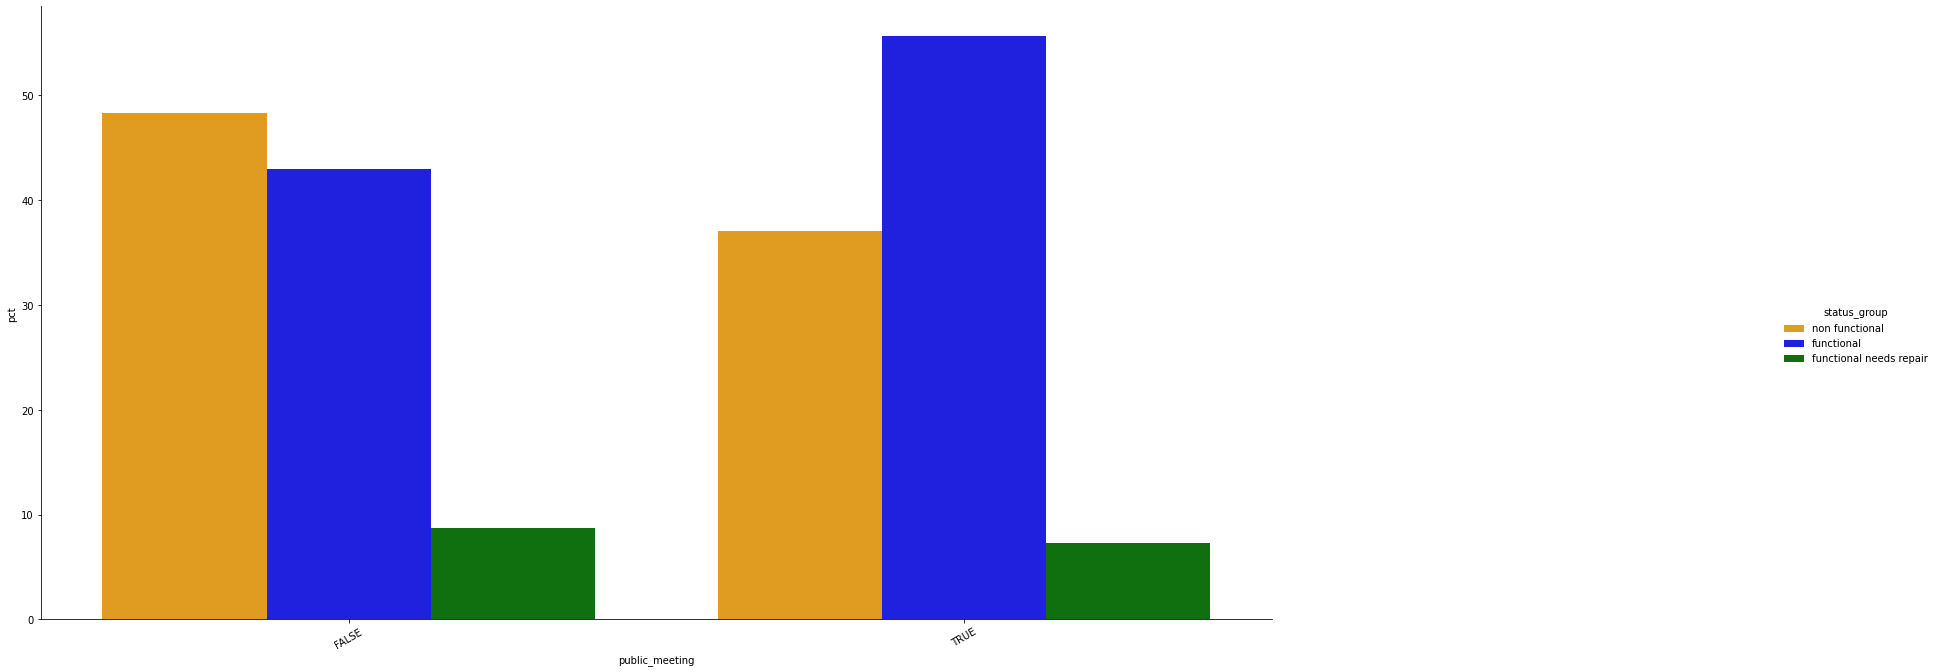

In [53]:
plot_normalised_bar_chart_hue(df_cat, column='public_meeting', dropna=False)

In [56]:
df_cat.scheme_management.value_counts(dropna=False)

VWC                 36792
WUG                  5205
NaN                  3877
Water authority      3153
WUA                  2882
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


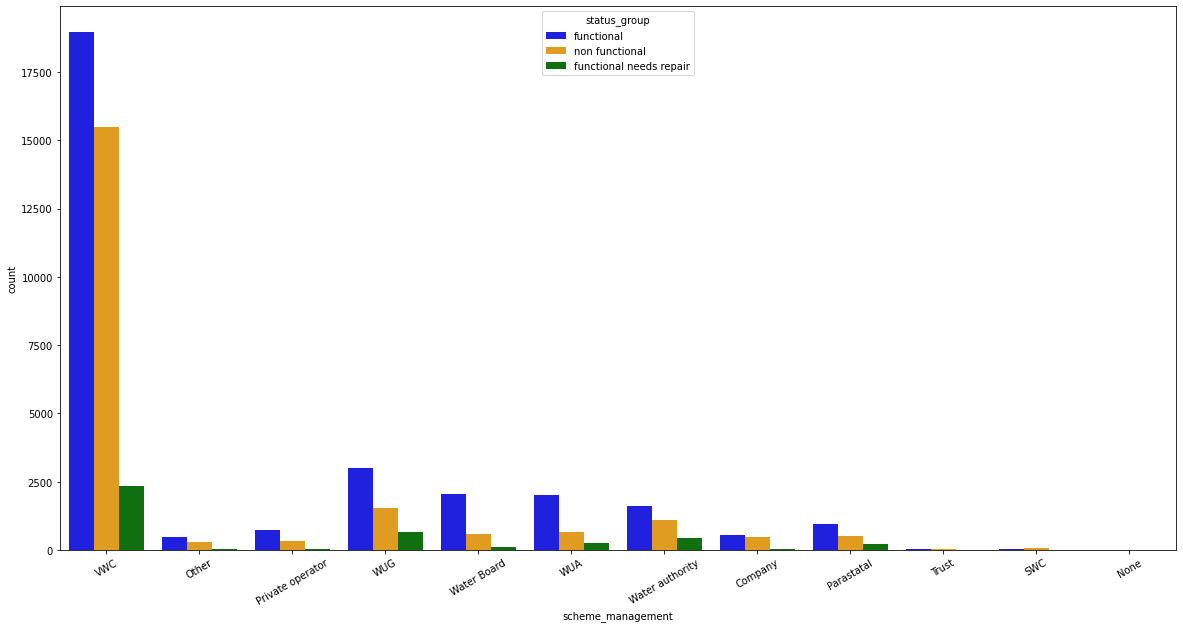

In [57]:
plot_bar_chart(df_cat, column='scheme_management')

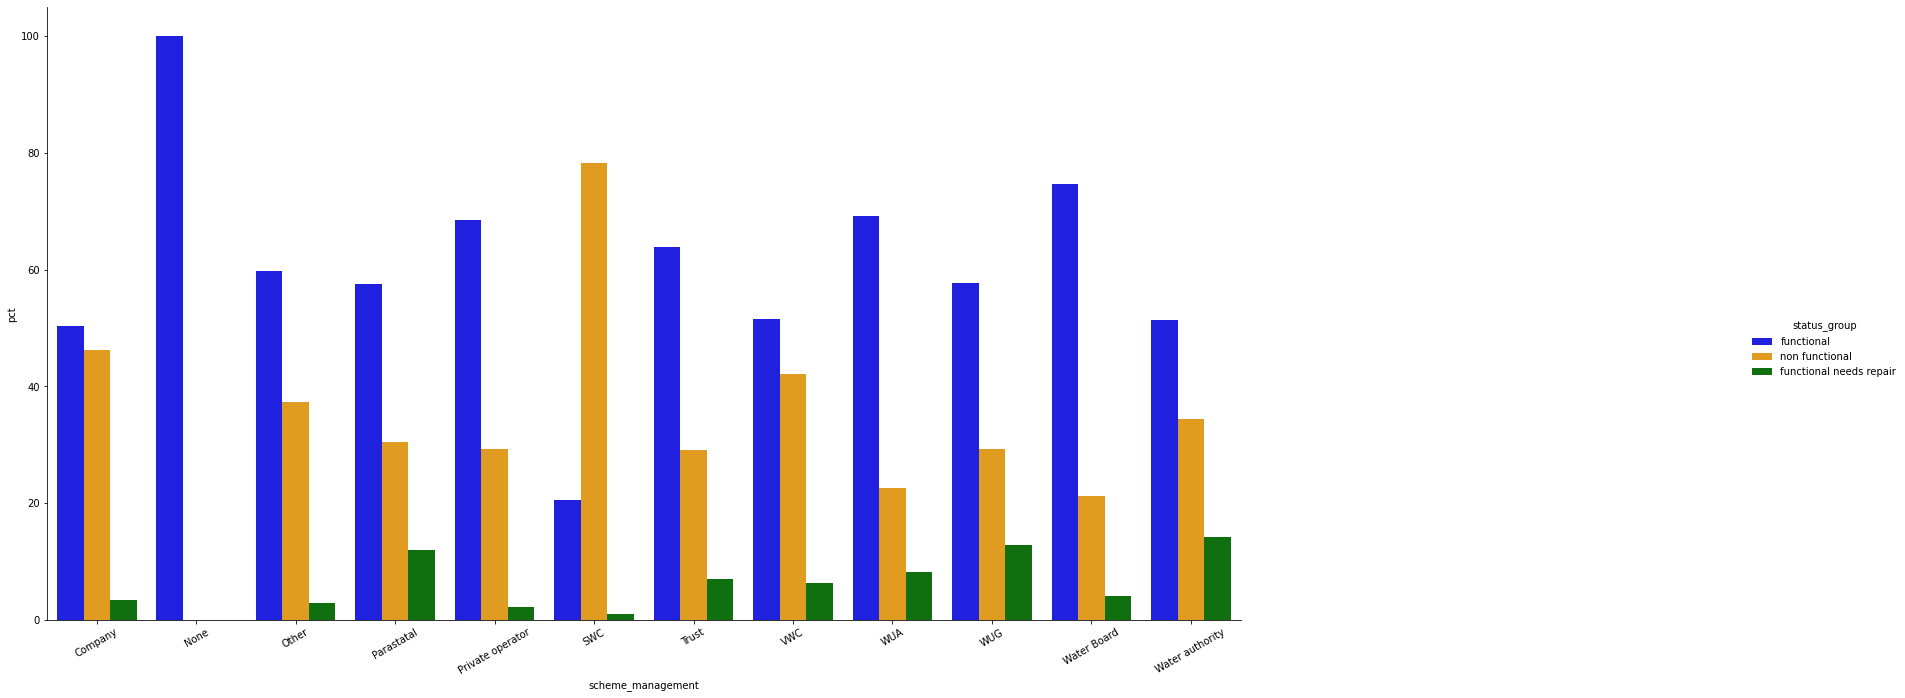

In [58]:
plot_normalised_bar_chart_hue(df_cat, column='scheme_management')

In [59]:
keep_scheme_name = keep_levels_greater_than_pct(df_cat, 'scheme_name')

AxesSubplot(0.125,0.125;0.775x0.755)


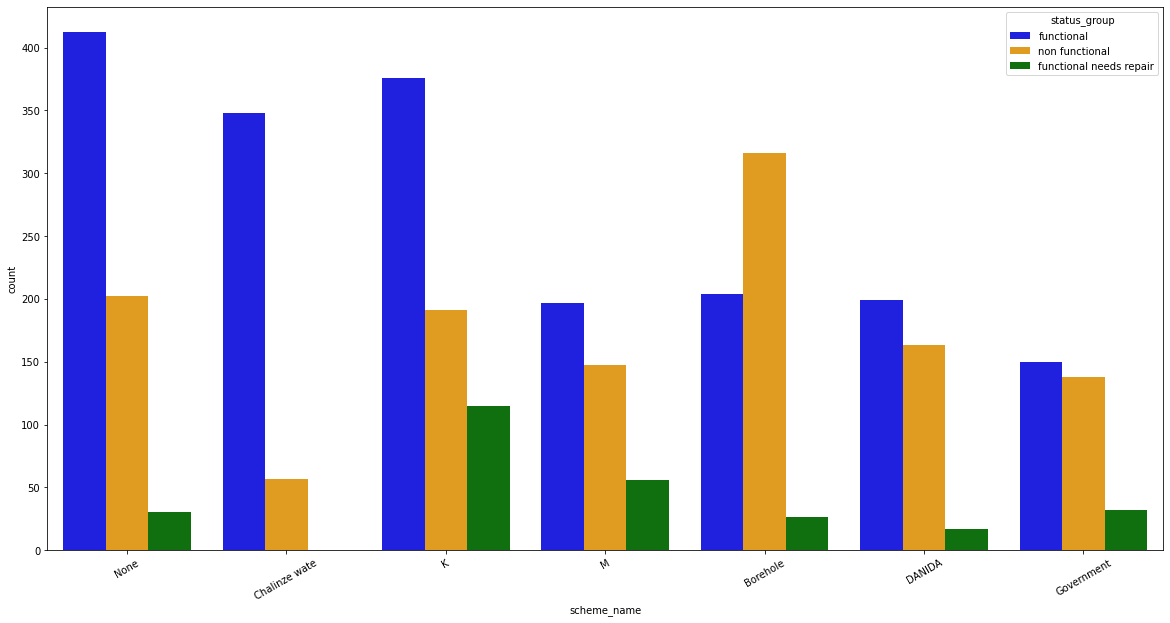

In [60]:
plot_bar_chart(df_cat[df_cat.scheme_name.isin(keep_scheme_name)], column='scheme_name')

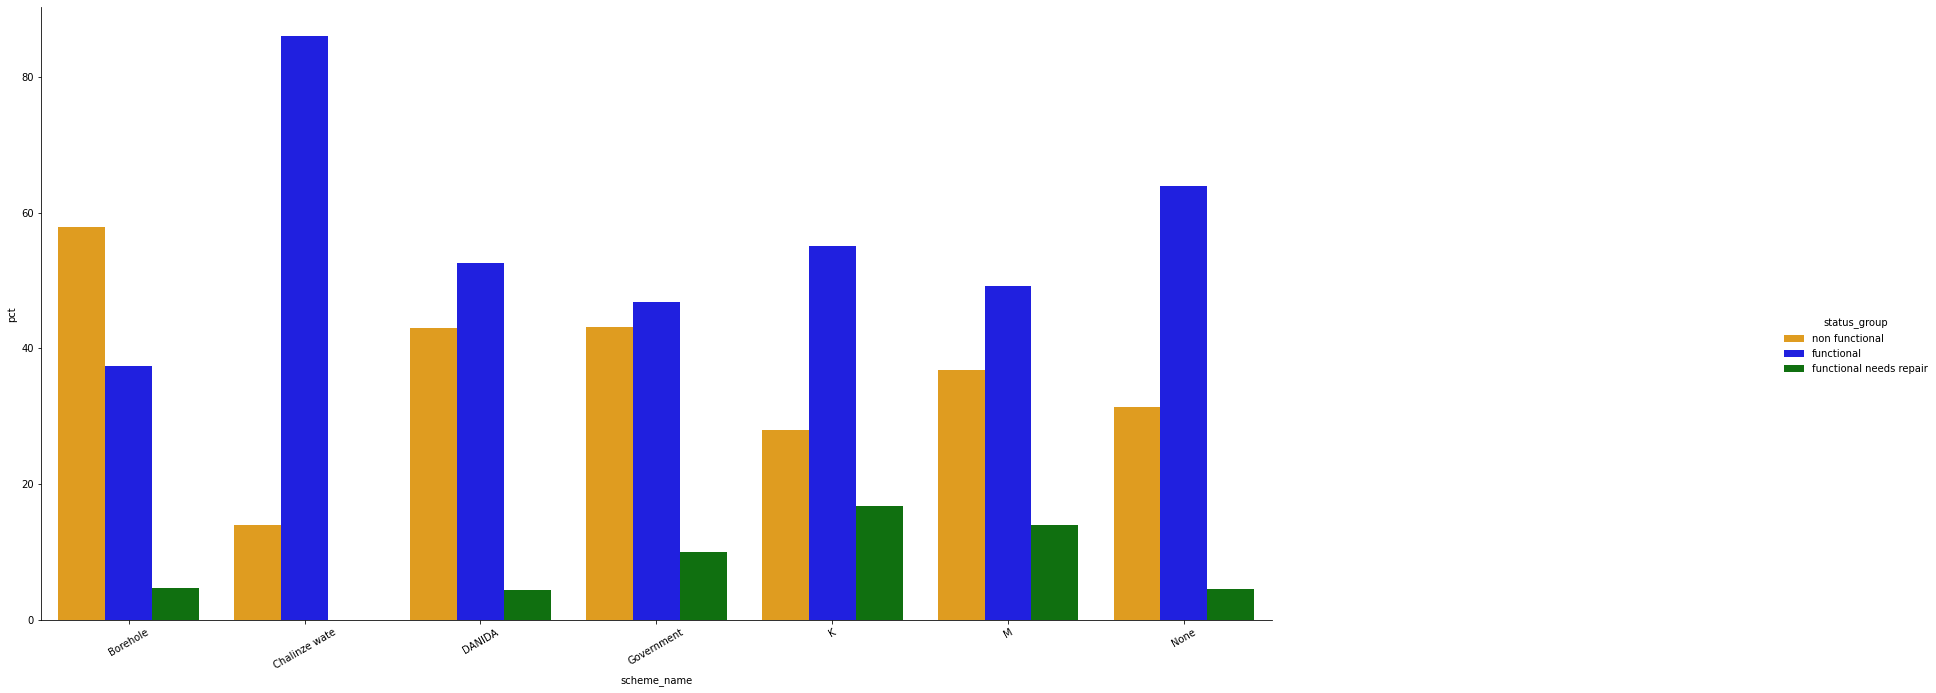

In [61]:
plot_normalised_bar_chart_hue(df_cat[df_cat.scheme_name.isin(keep_scheme_name)], column='scheme_name')

This task was becoming very time consuming and tedious. For the sake of time, I left it here but generally, when modelling categorical features, this is what I do:

* Fill missing with a value
* Combine levels in a column when they don't occupy a certain threshold, this helps when serving model and it sees something it's never seen before.
* Convert string to number
* encode if required by ML library (one hot or binary depending on number of levels)

# Correlation

From the data and heatmap below, correlation of continuous features isn't a big problem.

In general, highly correlated features can cause problems depending on the technique used and what you want from the model. From my experience, if you just care about prediction and are using a technique like logistic regression, correlated features don't matter too much. I know they can cause instability but have never seen it first hand. If you want to know why your model choose an answer and using logistic regression, then correlated features can make the interpretation hard. Correlated features in tree based models tends not to be a big deal.

If correlation was a big deal, you could remove one of the correlated variables or condense them to lower dimensionality.

In [62]:
df_contin = df_contin.drop(['status_group', 'date_recorded'], axis=1)

In [63]:
df_contin.head()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
0,6000,1390.0,34.938093,-9.856322,0,109,1999
1,0,1399.0,34.698766,-2.147466,0,280,2010
2,25,686.0,37.460664,-3.821329,0,250,2009
3,0,263.0,38.486161,-11.155298,0,58,1986
4,0,0.0,31.130847,-1.825359,0,0,0


In [64]:
corr_df = df_contin.corr()

In [65]:
corr_df

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
amount_tsh,1.000000,0.076650,0.022131,-0.052668,0.002944,0.016288,0.067916
gps_height,0.076650,1.000000,0.149105,-0.035727,0.007236,0.135009,0.658722
longitude,0.022131,0.149105,1.000000,-0.425750,0.023876,0.086568,0.396702
latitude,-0.052668,-0.035727,-0.425750,1.000000,0.006838,-0.022135,-0.245250
num_private,0.002944,0.007236,0.023876,0.006838,1.000000,0.003819,0.026056
population,0.016288,0.135009,0.086568,-0.022135,0.003819,1.000000,0.260898
construction_year,0.067916,0.658722,0.396702,-0.245250,0.026056,0.260898,1.000000


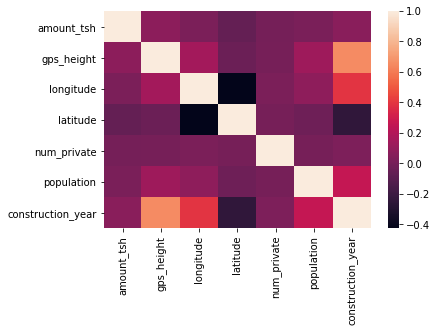

In [66]:
sns.heatmap(corr_df)